In [71]:
#analytics
import pandas as pd
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from entropy.entropy import *

from scipy.io import arff



# visuals
import matplotlib.pyplot as plt

## Import Condition Data

In [72]:
path = "data/useful/Plane/"

In [73]:
data = arff.loadarff(path+'Plane_TRAIN.arff')
print(len(data))
df_data = pd.DataFrame(data[0])

df_data.head()

2


,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att136,att137,att138,att139,att140,att141,att142,att143,att144,target
0,2.483940,2.276286,2.067516,1.921893,1.718775,1.508428,1.300675,1.090286,0.882733,0.672301,...,0.915860,1.120450,1.326346,1.532210,1.739919,1.945732,2.153986,2.361228,2.483939,b'1'
1,2.603320,2.340699,2.082285,1.825624,1.567706,1.312203,1.057195,0.801716,0.546683,0.291849,...,0.676066,0.921299,1.171722,1.418897,1.663607,1.915828,2.162467,2.405276,2.605294,b'4'
2,2.757321,2.576667,2.363323,2.151578,1.940218,1.729427,1.519429,1.309547,1.100253,0.891493,...,1.157343,1.363317,1.566326,1.769860,1.973864,2.178290,2.380841,2.584945,2.759135,b'6'
3,0.916063,0.720145,0.522445,0.325826,0.134381,-0.054012,-0.235525,-0.409605,-0.574453,-0.782353,...,0.984352,0.760642,0.541502,0.517342,0.582836,0.658641,0.757901,0.853401,0.916217,b'5'
4,2.656142,2.388145,2.118595,1.849677,1.576579,1.310169,1.109699,0.930998,0.750668,0.539333,...,0.792403,0.986072,1.178943,1.392679,1.660325,1.929237,2.199162,2.469993,2.655524,b'2'


In [74]:
Xtrain = df_data.drop(columns=['target']).values
ytrain = df_data['target']

In [75]:
Xtrain[0].shape

(144,)

In [76]:
ytrain.shape

(105,)

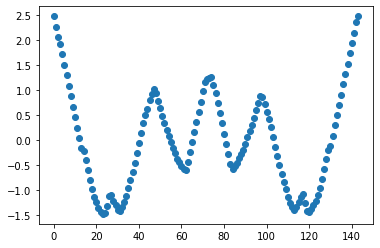

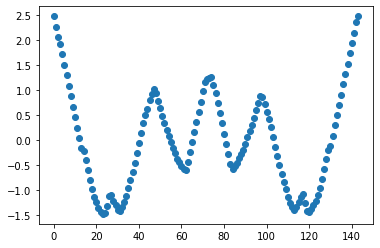

In [77]:
x_range = [x for x in range(0,len(Xtrain[0]))]

initial_fig, initial_ax = plt.subplots(1,1)
initial_ax = plt.scatter(x_range,Xtrain[0])
initial_fig

## Extract Features

### Extracting the following features from selected data

<ol>
<li>Mean Activity Level</li>
<li>Standard Deviation</li>
<li> Trimmed Mean </li>
</ol>

In [78]:
training_data_raw = Xtrain

In [79]:
def normalise(X):
    return [(x - min(X))/(max(X)-min(X)) for x in X]

In [80]:
from scipy.stats import trim_mean
    
df_features = pd.DataFrame()
df_features['normalised_training_mean'] = normalise([np.mean(x) for x in training_data_raw])
df_features['normalised_training_std'] = normalise([np.std(x) for x in training_data_raw])

df_features['perm_entropy'] = normalise([perm_entropy(x,10) for x in training_data_raw])
df_features['sample_entropy'] = normalise([sample_entropy(x,2) for x in training_data_raw])
df_features['app_entropy'] = normalise([app_entropy(x,2) for x in training_data_raw])
df_features['svd_entropy'] = normalise([svd_entropy(x,3) for x in training_data_raw])
#df_features['spectral_entropy'] = normalise([spectral_entropy(x,100) for x in training_data_raw])

In [81]:
feature_combinations = []

feature_names = ['perm', 'sample', 'app', 'svd']
# singles
feature_combinations.append(df_features.drop(['sample_entropy', 'app_entropy', 'svd_entropy'],axis=1).values)
feature_combinations.append(df_features.drop(['perm_entropy', 'app_entropy', 'svd_entropy'],axis=1).values)
feature_combinations.append(df_features.drop(['perm_entropy', 'sample_entropy', 'svd_entropy'],axis=1).values)
feature_combinations.append(df_features.drop(['perm_entropy', 'sample_entropy', 'app_entropy'],axis=1).values)




In [82]:
y_temp = ytrain.values

y = [x[0] for x in y_temp]

## Naive Bayes

In [83]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
accuracy_scores = []
f1_scores = []

for X in feature_combinations:
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy'))
    f1_scores.append(cross_val_score(clf, X, y, cv=5, scoring='f1_weighted'))

In [84]:
len(accuracy_scores)

4

In [85]:
print(np.mean(accuracy_scores,axis=1))



[0.4952381  0.54285714 0.46666667 0.68571429]


1: perm
2: sample
3: app
4: svd


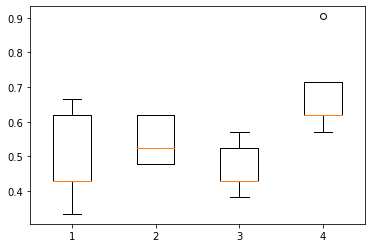

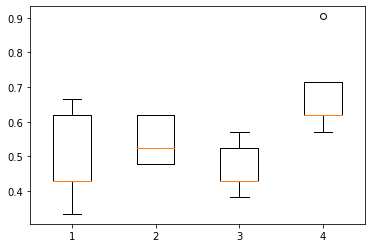

In [86]:
## Accuracy Plot
from matplotlib.pyplot import boxplot

box_plot = plt.subplots(1,1)
box_fig, box_ax = box_plot
box_ax.boxplot(accuracy_scores)
#box_ax.set_xticklabels(feature_names)

for x in range(1,len(feature_names)+1):
    
    print(str(x) + ': '+  str(feature_names[x - 1]))
    
box_fig
    

In [87]:
import random

print(type(Xtrain))

random_sample = random.sample(list(Xtrain), 10)

<class 'numpy.ndarray'>


In [88]:
from statsmodels.tsa.stattools import adfuller
mean_adf = []
mean_p = []

for X in random_sample:
    result = adfuller(X)
    mean_adf.append(result[0])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    mean_p.append(result[1])
    if result[1] < 0.05:
        print("can_reject")
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
print("adf_mean is: ")
print(np.mean(mean_adf))
print(np.mean(mean_p))

ADF Statistic: -2.605993
p-value: 0.091765
Critical Values:
	1%: -3.478
	5%: -2.882
	10%: -2.578
ADF Statistic: -2.384173
p-value: 0.146253
Critical Values:
	1%: -3.480
	5%: -2.883
	10%: -2.578
ADF Statistic: -3.495401
p-value: 0.008106
can_reject
Critical Values:
	1%: -3.477
	5%: -2.882
	10%: -2.578
ADF Statistic: -3.941860
p-value: 0.001747
can_reject
Critical Values:
	1%: -3.480
	5%: -2.883
	10%: -2.578
ADF Statistic: -2.855342
p-value: 0.050793
Critical Values:
	1%: -3.478
	5%: -2.882
	10%: -2.578
ADF Statistic: -2.443360
p-value: 0.129870
Critical Values:
	1%: -3.480
	5%: -2.883
	10%: -2.578
ADF Statistic: -2.206853
p-value: 0.203768
Critical Values:
	1%: -3.478
	5%: -2.882
	10%: -2.578
ADF Statistic: -2.856455
p-value: 0.050651
Critical Values:
	1%: -3.478
	5%: -2.882
	10%: -2.578
ADF Statistic: -2.765551
p-value: 0.063366
Critical Values:
	1%: -3.477
	5%: -2.882
	10%: -2.578
ADF Statistic: -2.797465
p-value: 0.058637
Critical Values:
	1%: -3.478
	5%: -2.882
	10%: -2.578
adf_mean

In [89]:
for X in random_sample:
    split = round(len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print('mean1=%f, mean2=%f' % (mean1, mean2))
    print('variance1=%f, variance2=%f' % (var1, var2))

mean1=-0.006167, mean2=0.006167
variance1=0.975752, variance2=1.010283
mean1=0.033322, mean2=-0.033322
variance1=0.988511, variance2=0.995380
mean1=0.159124, mean2=-0.159124
variance1=1.312681, variance2=0.622789
mean1=-0.022512, mean2=0.022512
variance1=1.054082, variance2=0.931015
mean1=0.007290, mean2=-0.007290
variance1=0.898660, variance2=1.087345
mean1=0.029588, mean2=-0.029588
variance1=0.980713, variance2=1.003647
mean1=0.040420, mean2=-0.040420
variance1=0.954311, variance2=1.028532
mean1=-0.010168, mean2=0.010168
variance1=1.044567, variance2=0.941338
mean1=-0.077587, mean2=0.077587
variance1=0.919004, variance2=1.055067
mean1=-0.163897, mean2=0.163897
variance1=0.948941, variance2=0.983445


### Test for Auto-correlation

In [90]:
from statsmodels.stats.stattools import durbin_watson
from statsmodels.regression.linear_model import OLS


def dw(data):
    ols_res = OLS(data, np.ones(len(data))).fit()
    return durbin_watson(ols_res.resid)



In [91]:
mean = []
for X in random_sample:
    print(dw(X))
    mean.append(dw(X))

print("mean is: ")
print(np.mean(mean))

0.03258605434360938
0.023000330929582882
0.02480563588152309
0.05040919094626131
0.021007429691420287
0.02252341046016667
0.02214473662562275
0.029199330903869416
0.03153856969014461
0.01959874419846268
mean is: 
0.02768134336706631


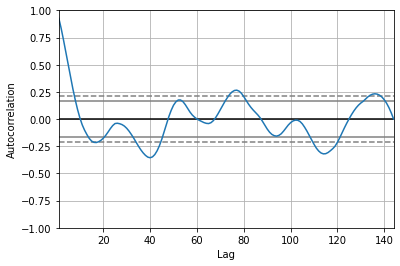

In [92]:
from pandas.plotting import autocorrelation_plot

my_plot = autocorrelation_plot(random_sample[0])

plt.show()

## Matrix Profile Feature

In [93]:
def new_discord_entropy(matrix_profile, window_size):
    # size of time_series
    time_series_size = len(matrix_profile)
    
    df_matrix_profile = pd.DataFrame()
    df_matrix_profile['distances']= matrix_profile[:,0]
    df_matrix_profile['index'] = matrix_profile[:,1]
    
    top_discords = df_matrix_profile.sort_values(by='distances')[0:10]

    #top 10 discords
    top_discord_windows = []
    for x in top_discords['index']:
        window = np.arange(x,x+window_size,1)
        top_discord_windows.append(window)
    overall_discord_window = set(np.concatenate(top_discord_windows))
    discord_size = len(overall_discord_window)
    discord_probability = discord_size/time_series_size


    discord_entropy = -(discord_probability * np.log2(discord_probability))
    
    return discord_entropy
    

In [94]:
def new_motif_entropy(matrix_profile, window_size):
    # size of time_series
    time_series_size = len(matrix_profile)
    
    df_matrix_profile = pd.DataFrame()
    df_matrix_profile['distances']= matrix_profile[:,0]
    df_matrix_profile['index'] = matrix_profile[:,1]
    
    top_motifs = df_matrix_profile.sort_values(by='distances')[0:10]

    # top 10 motifs 
    top_motif_windows = []
    for x in top_motifs['index']:
        window = np.arange(x,x+window_size,1)
        top_motif_windows.append(window)
    overall_motif_window = set(np.concatenate(top_motif_windows))
    motif_size = len(overall_motif_window)
    motif_probability = motif_size/time_series_size

    motif_entropy = -(motif_probability * np.log2(motif_probability))
    
    return motif_entropy

In [95]:
def motif_entropy(matrix_profile):
    df_matrix_profile = pd.DataFrame()
    df_matrix_profile['distances']= matrix_profile[:,0]
    df_matrix_profile['index'] = matrix_profile[:,1]
    df_matrix_profile['index_left'] = matrix_profile[:,2]
    df_matrix_profile['index_right'] = matrix_profile[:,3]
    
    top_motifs = df_matrix_profile.sort_values(by='distances')[0:100]
    entropy_motif = np.sum(np.asarray([x * np.log2(x) for x in top_motifs['distances']]))
    
    return entropy_motif

In [96]:
def discord_entropy(matrix_profile):
    df_matrix_profile = pd.DataFrame()
    df_matrix_profile['distances']= matrix_profile[:,0]
    df_matrix_profile['index'] = matrix_profile[:,1]
    df_matrix_profile['index_left'] = matrix_profile[:,2]
    df_matrix_profile['index_right'] = matrix_profile[:,3]
    
    top_discords = df_matrix_profile.sort_values(by='distances')[len(df_matrix_profile)-200:len(df_matrix_profile)] 
    entropy_discord = np.sum(np.asarray([x * np.log2(x) for x in top_discords['distances']]))
    
    return entropy_discord

In [97]:
def distance_entropy(matrix_profile):
    df_matrix_profile = pd.DataFrame()
    df_matrix_profile['distances']= matrix_profile[:,0]
    df_matrix_profile['index'] = matrix_profile[:,1]
    df_matrix_profile['index_left'] = matrix_profile[:,2]
    df_matrix_profile['index_right'] = matrix_profile[:,3]
    
    max_discord = max(df_matrix_profile['distances'])
    entropy_distance = np.sum(np.asarray([-np.multiply((x/max_discord), np.log2(x/max_discord)).sum() for x in df_matrix_profile['distances']]))
    
    return entropy_distance

In [98]:
def calculate_matrix_profile(data, window_size):
    time_series = np.array(data, dtype=float)
    matrix_profile = stumpy.stump(time_series, m=window_size)    
    return matrix_profile

In [99]:
import stumpy

df_features = pd.DataFrame()
df_features['normalised_training_mean'] = normalise([np.mean(x) for x in training_data_raw])
df_features['normalised_training_std'] = normalise([np.std(x) for x in training_data_raw])

window_size = 10
matrix_profiles = [calculate_matrix_profile(x,window_size) for x in training_data_raw]

In [100]:
df_features['new_motif_entropy'] = normalise([new_motif_entropy(x, window_size) for x in matrix_profiles])
df_features['new_discord_entropy'] = normalise([new_discord_entropy(x, window_size) for x in matrix_profiles])
df_features['motif_entropy'] = normalise([motif_entropy(x) for x in matrix_profiles])
df_features['discord_entropy'] = normalise([discord_entropy(x) for x in matrix_profiles])
#df_features['distance_entropy'] = normalise([distance_entropy(x) for x in matrix_profiles])

In [101]:
entropy_feature_combinations = []

entropy_feature_names = ['new_motif_entropy', 'new_discord_entropy', 'motif_entropy', 'discord_entropy']
# singles
entropy_feature_combinations.append(df_features.drop(['new_discord_entropy', 'motif_entropy', 'discord_entropy'],axis=1).values)
entropy_feature_combinations.append(df_features.drop(['new_motif_entropy', 'motif_entropy', 'discord_entropy'],axis=1).values)
entropy_feature_combinations.append(df_features.drop(['new_motif_entropy', 'new_discord_entropy', 'discord_entropy'],axis=1).values)
entropy_feature_combinations.append(df_features.drop(['new_motif_entropy', 'new_discord_entropy', 'motif_entropy'],axis=1).values)


In [102]:
accuracy_scores = []
f1_scores = []

for X in entropy_feature_combinations:
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy'))
    f1_scores.append(cross_val_score(clf, X, y, cv=5, scoring='f1_weighted'))

In [103]:
np.mean(accuracy_scores)

0.3476190476190476

In [104]:
np.mean(f1_scores)

0.31608670430099

1: new_motif_entropy
2: new_discord_entropy
3: motif_entropy
4: discord_entropy


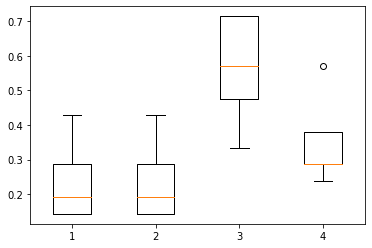

In [105]:
## Accuracy Plot
from matplotlib.pyplot import boxplot

box_plot = plt.subplots(1,1)
box_fig, box_ax = box_plot
box_ax.boxplot(accuracy_scores)
#box_ax.set_xticklabels(feature_names)

for x in range(1,len(entropy_feature_names)+1):
    
    print(str(x) + ': '+  str(entropy_feature_names[x - 1]))
    



1: new_motif_entropy
2: new_discord_entropy
3: motif_entropy
4: discord_entropy


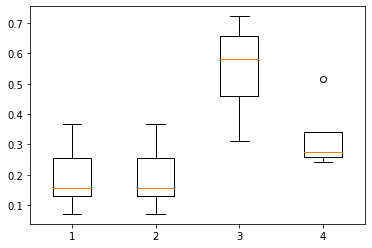

In [106]:
## Accuracy Plot
from matplotlib.pyplot import boxplot

box_plot = plt.subplots(1,1)
box_fig, box_ax = box_plot
box_ax.boxplot(f1_scores)
#box_ax.set_xticklabels(feature_names)

for x in range(1,len(entropy_feature_names)+1):
    
    print(str(x) + ': '+  str(entropy_feature_names[x - 1]))
    

